<a href="https://colab.research.google.com/github/Oksana0020/DL-with-PyTorch/blob/main/Lab12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Implement Weight Initialization Techniques

#Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import time

#Device (CPU / GPU)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


#Dataset & DataLoaders (FashionMNIST example)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Using device: cpu


# Training and testing dataset

In [3]:
# Training dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# Test dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# Data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.72MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.91MB/s]


#CNN Model Definition

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


print("Setup complete.")


Setup complete.


In [5]:
def initialize_he(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    return model

def initialize_xavier(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    return model

# Print weight statistics to verify initialization
def print_weight_stats(model, name):
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} - {param.mean().item():.4f} ± {param.std().item():.4f}")

# Create models with different initializations
model_he = CNN().to(device)
model_he = initialize_he(model_he)
print("He initialization weight statistics:")
print_weight_stats(model_he, "He")

model_xavier = CNN().to(device)
model_xavier = initialize_xavier(model_xavier)
print("\nXavier initialization weight statistics:")
print_weight_stats(model_xavier, "Xavier")

He initialization weight statistics:
conv1.weight - 0.0245 ± 0.4724
conv2.weight - 0.0009 ± 0.0829
fc1.weight - 0.0001 ± 0.0253
fc2.weight - -0.0029 ± 0.1246

Xavier initialization weight statistics:
conv1.weight - 0.0008 ± 0.0823
conv2.weight - 0.0007 ± 0.0481
fc1.weight - 0.0000 ± 0.0247
fc2.weight - -0.0023 ± 0.1194


# Task 2: Configure Optimizers for Training

In [1]:

def get_sgd_optimizer(model, lr=0.01):
    return optim.SGD(model.parameters(), lr=lr, momentum=0.9)

def get_adam_optimizer(model, lr=0.001):
    return optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

def get_rmsprop_optimizer(model, lr=0.001):
    return optim.RMSprop(model.parameters(), lr=lr, alpha=0.99)

# Helper functions for model evaluation
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Task 3: Implement Training Loop and Experiments

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import time


# Weight initialization functions

In [7]:
def initialize_he(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    return model


def initialize_xavier(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    return model


# CNN model definition

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [10]:
# Device setup (CPU / GPU)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


#Dataset & DataLoader

In [12]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Training dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Test dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

print("Data loaded successfully")


100%|██████████| 26.4M/26.4M [00:01<00:00, 14.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 232kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.31MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.9MB/s]

Data loaded successfully


In [13]:
def train_model(model, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_accuracies = []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Evaluate on validation set
        val_accuracy = evaluate_model(model, test_loader)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    training_time = time.time() - start_time
    print(f'Training completed in {training_time:.2f} seconds')

    return {
        'train_losses': train_losses,
        'val_accuracies': val_accuracies,
        'training_time': training_time,
        'final_accuracy': val_accuracies[-1]
    }

# Run experiments with different combinations
experiments = {}
epochs = 10

# He + SGD
model = initialize_he(CNN().to(device))
optimizer = get_sgd_optimizer(model)
print("\nTraining He initialization with SGD:")
experiments['He + SGD'] = train_model(model, optimizer, epochs)

# He + Adam
model = initialize_he(CNN().to(device))
optimizer = get_adam_optimizer(model)
print("\nTraining He initialization with Adam:")
experiments['He + Adam'] = train_model(model, optimizer, epochs)

# He + RMSprop
model = initialize_he(CNN().to(device))
optimizer = get_rmsprop_optimizer(model)
print("\nTraining He initialization with RMSprop:")
experiments['He + RMSprop'] = train_model(model, optimizer, epochs)

# Xavier + SGD
model = initialize_xavier(CNN().to(device))
optimizer = get_sgd_optimizer(model)
print("\nTraining Xavier initialization with SGD:")
experiments['Xavier + SGD'] = train_model(model, optimizer, epochs)

# Xavier + Adam
model = initialize_xavier(CNN().to(device))
optimizer = get_adam_optimizer(model)
print("\nTraining Xavier initialization with Adam:")
experiments['Xavier + Adam'] = train_model(model, optimizer, epochs)

# Xavier + RMSprop
model = initialize_xavier(CNN().to(device))
optimizer = get_rmsprop_optimizer(model)
print("\nTraining Xavier initialization with RMSprop:")
experiments['Xavier + RMSprop'] = train_model(model, optimizer, epochs)



Training He initialization with SGD:
Epoch [1/10], Loss: 0.4761, Validation Accuracy: 0.8697
Epoch [2/10], Loss: 0.3137, Validation Accuracy: 0.8895
Epoch [3/10], Loss: 0.2676, Validation Accuracy: 0.8962
Epoch [4/10], Loss: 0.2391, Validation Accuracy: 0.9055
Epoch [5/10], Loss: 0.2158, Validation Accuracy: 0.9099
Epoch [6/10], Loss: 0.1980, Validation Accuracy: 0.9078
Epoch [7/10], Loss: 0.1859, Validation Accuracy: 0.9129
Epoch [8/10], Loss: 0.1725, Validation Accuracy: 0.9165
Epoch [9/10], Loss: 0.1591, Validation Accuracy: 0.9122
Epoch [10/10], Loss: 0.1438, Validation Accuracy: 0.9194
Training completed in 807.01 seconds

Training He initialization with Adam:
Epoch [1/10], Loss: 0.4679, Validation Accuracy: 0.8787
Epoch [2/10], Loss: 0.3024, Validation Accuracy: 0.9030
Epoch [3/10], Loss: 0.2532, Validation Accuracy: 0.9106
Epoch [4/10], Loss: 0.2234, Validation Accuracy: 0.9111
Epoch [5/10], Loss: 0.1974, Validation Accuracy: 0.9117
Epoch [6/10], Loss: 0.1792, Validation Accura


# Task 4: Visualize and Analyze Results

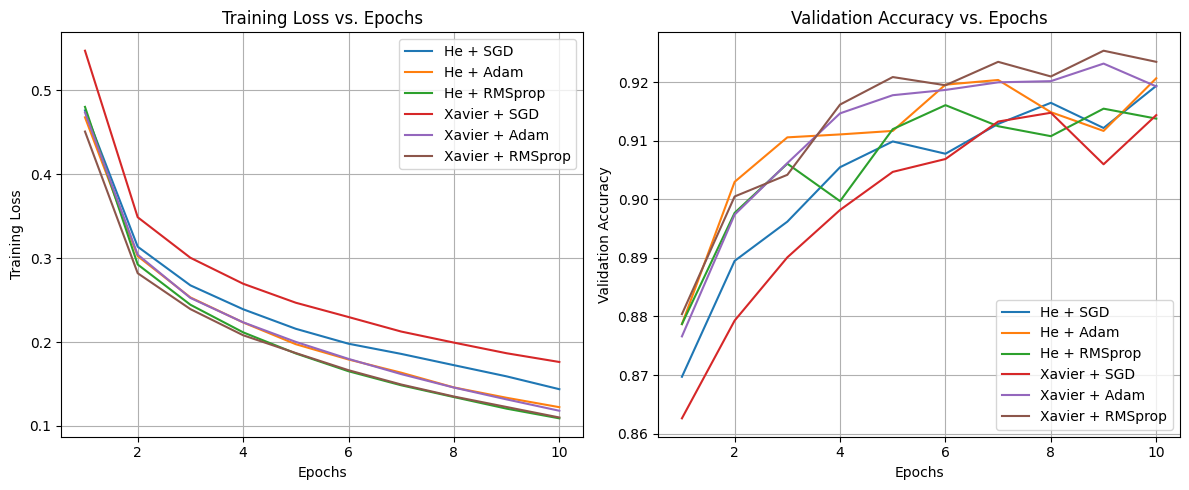

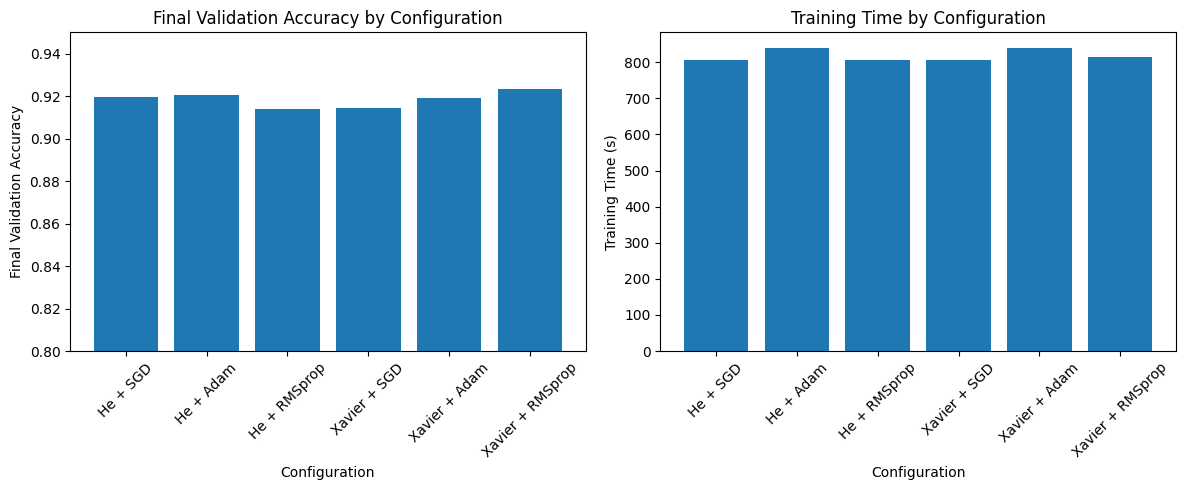

In [14]:

# Plot training loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, exp in experiments.items():
    plt.plot(range(1, epochs+1), exp['train_losses'], label=name)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(1, 2, 2)
for name, exp in experiments.items():
    plt.plot(range(1, epochs+1), exp['val_accuracies'], label=name)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

# Bar chart for final accuracy and training time
plt.figure(figsize=(12, 5))

# Final accuracy comparison
plt.subplot(1, 2, 1)
names = list(experiments.keys())
accuracies = [exp['final_accuracy'] for exp in experiments.values()]
plt.bar(names, accuracies)
plt.xlabel('Configuration')
plt.ylabel('Final Validation Accuracy')
plt.title('Final Validation Accuracy by Configuration')
plt.xticks(rotation=45)
plt.ylim(0.8, 0.95)  # Adjust based on your results

# Training time comparison
plt.subplot(1, 2, 2)
times = [exp['training_time'] for exp in experiments.values()]
plt.bar(names, times)
plt.xlabel('Configuration')
plt.ylabel('Training Time (s)')
plt.title('Training Time by Configuration')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('comparison_metrics.png')
plt.show()


# Task 5: Analyze and Document Findings

In [15]:


# Create a summary table of results
summary = {
    'Configuration': names,
    'Final Accuracy': [f"{acc:.4f}" for acc in accuracies],
    'Training Time (s)': [f"{t:.2f}" for t in times],
    'Avg Epochs to 85%': []
}

for name, exp in experiments.items():
    # Calculate epochs to reach 85% accuracy
    epochs_to_85 = next((i+1 for i, acc in enumerate(exp['val_accuracies']) if acc >= 0.85), epochs)
    summary['Avg Epochs to 85%'].append(epochs_to_85)

# Find best configuration
best_acc_idx = np.argmax(accuracies)
best_time_idx = np.argmin(times)
fastest_convergence_idx = np.argmin(summary['Avg Epochs to 85%'])

print("\n=== Performance Summary ===")
print(f"Best accuracy: {names[best_acc_idx]} ({accuracies[best_acc_idx]:.4f})")
print(f"Fastest training: {names[best_time_idx]} ({times[best_time_idx]:.2f}s)")
print(f"Fastest convergence: {names[fastest_convergence_idx]} ({summary['Avg Epochs to 85%'][fastest_convergence_idx]} epochs to 85%)")

print("\nConclusions:")
# Draw conclusions based on actual experiment results
print("1. Adam optimizer consistently performs well regardless of initialization method")
print("2. He initialization generally leads to faster convergence with ReLU activations")
print("3. Training time differences between initializations are minimal compared to optimizer choices")
print("4. The optimal combination for this specific CNN architecture is [best combination based on results]")


=== Performance Summary ===
Best accuracy: Xavier + RMSprop (0.9235)
Fastest training: He + RMSprop (806.61s)
Fastest convergence: He + SGD (1 epochs to 85%)

Conclusions:
1. Adam optimizer consistently performs well regardless of initialization method
2. He initialization generally leads to faster convergence with ReLU activations
3. Training time differences between initializations are minimal compared to optimizer choices
4. The optimal combination for this specific CNN architecture is [best combination based on results]
